# Introduction
Hello my Name is Nurfaldi, I'm a data scientist and today I want to show you the application of SVM and Logistic Regression

In [1]:
#SQL Query to fetch data from Google cloud platform with filter:
#### hours per week < 100
#### workclass != ' ?'
#### data is sampeled at random
SQLQuery = (
'''
SELECT
age, workclass, education, education_num, marital_status, occupation, relationship,
race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket
FROM `bigquery-public-data.ml_datasets.census_adult_income` 
WHERE (hours_per_week < 100)
AND (workclass != ' ?')
ORDER BY RAND()
LIMIT 19940
'''
)

## Description

### Objective

In this project, I'll try to analyze US census data. we are given several variables that we can utilize to analyze the income of us citizens. along the way we would also try to analyze the data and find insight that can helps us predict the income.

### Problem Statement

The main problem that I wanted to answer is how variables in our data impact income. to answer this we will try to build machine learning model using logistic regression  and SVM. other than that we will also explore the corelation between the data on our expolration.  

# Import Libraries

In [2]:
# Import library

# Standard Python Libraries
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Data Science Libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

## Outlier handler
from feature_engine.outliers import Winsorizer

## Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Encoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

## Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Evaluation Metrics
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [3]:
sns.set_theme(style="whitegrid")

# Data Loading

In [4]:
#import data
df = pd.read_csv('../data/US_citizen_data_income.csv')

#Calling dataframe head and tail
df_head_tail = pd.concat([df.head(3), df.tail(3)])
df_head_tail.T

,0,1,2,19937,19938,19939
age,20,75,59,51,34,27
workclass,Private,Self-emp-not-inc,State-gov,Federal-gov,Private,Private
education,HS-grad,HS-grad,Some-college,Doctorate,HS-grad,HS-grad
education_num,9,9,10,16,9,9
marital_status,Never-married,Married-civ-spouse,Divorced,Never-married,Divorced,Married-civ-spouse
occupation,Adm-clerical,Farming-fishing,Adm-clerical,Prof-specialty,Prof-specialty,Machine-op-inspct
relationship,Not-in-family,Husband,Not-in-family,Not-in-family,Unmarried,Wife
race,White,White,White,White,White,White
sex,Female,Male,Female,Female,Male,Female
capital_gain,0,3456,0,0,0,0


In [5]:
df.shape

(19940, 14)

In [6]:
#Duplicate data for backup
df_copy = df.copy()

# Exploratory Data Analysis (EDA)

## Cleaning

In [7]:
#Listing all columns
df.columns

Index(['age', 'workclass', 'education', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income_bracket'],
      dtype='object')

In [8]:
df.select_dtypes(include=['object']).columns

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income_bracket'],
      dtype='object')

Generally the column name are orderly and ready for exploration and refined cleaning

In [9]:
#checking the data as a list
df.sample(1).values.tolist()

[[33,
  ' Self-emp-not-inc',
  ' Bachelors',
  13,
  ' Married-civ-spouse',
  ' Sales',
  ' Husband',
  ' White',
  ' Male',
  0,
  0,
  45,
  ' United-States',
  ' >50K']]

As we can see the data contain leading space so we would need to clean this out

In [10]:
#Cleaning leading and trailing spaces
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

#checking the result    
df.sample(1).values.tolist()

[[47,
  'Private',
  'Some-college',
  10,
  'Married-civ-spouse',
  'Exec-managerial',
  'Husband',
  'White',
  'Male',
  0,
  0,
  40,
  'United-States',
  '>50K']]

We can see that leading and trailing spaces are already cleaned

In [11]:
#Checking for duplicated rows
df.duplicated().sum()

1627

There are 1627 duplicated value in our data, let see those values

In [12]:
#checking the data that have duplicates
df[df.duplicated()].head(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
522,26,Private,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
569,30,Private,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K
693,63,Self-emp-not-inc,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
773,19,Private,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,20,United-States,<=50K
807,27,Private,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States,<=50K


Because most of the data types inside the columns is categorcal (except age and hours per week, education_num is infered from education). I'm going to assume that this duplicates is coincidence since there's only limited category and it highly is probable duplicates accidentaly occur.

In [13]:
#Checking non-null values count and data types. it seems there is some null value and wrong datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19940 non-null  int64 
 1   workclass       19940 non-null  object
 2   education       19940 non-null  object
 3   education_num   19940 non-null  int64 
 4   marital_status  19940 non-null  object
 5   occupation      19940 non-null  object
 6   relationship    19940 non-null  object
 7   race            19940 non-null  object
 8   sex             19940 non-null  object
 9   capital_gain    19940 non-null  int64 
 10  capital_loss    19940 non-null  int64 
 11  hours_per_week  19940 non-null  int64 
 12  native_country  19940 non-null  object
 13  income_bracket  19940 non-null  object
dtypes: int64(5), object(9)
memory usage: 2.1+ MB


It looks like that there are no Null values in the data, but if we would explore the data more, we would see that Nan values will be written as ' ?'. so we will try to find those cells with ' ?'

In [14]:
# Counting Nan Values and it's column
substring = '?'
mask = df.applymap(lambda x: substring in x.lower() if isinstance(x,str) else False).to_numpy()
indices = np.argwhere(mask)

pd.DataFrame(indices, columns=('loc','column_no')).groupby('column_no').count()

,loc
column_no,
5,5
12,372


we can see that there is 5 Nan values in column 5 (occupation) and 372 Nan values in column 12 (native country). this amount is not significant so we will change this value to Nan to handle later if necessary

In [15]:
#replacing '?' with nan
df = df.replace('?', np.nan)

In [16]:
#confirming the count of null values
df.isnull().sum()

age                 0
workclass           0
education           0
education_num       0
marital_status      0
occupation          5
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    372
income_bracket      0
dtype: int64

Now we will explore the data

## Data Types Exploration

We will start by checking every data features for pattern. fist we want to see potential categorical features. We can start by looking at unique values for each column and look for low count unique values. 

In [17]:
#Checking Unique Values of every columns
df.nunique().sort_values()

sex                 2
income_bracket      2
race                5
relationship        6
marital_status      7
workclass           8
occupation         14
education          16
education_num      16
native_country     41
age                72
capital_loss       83
hours_per_week     93
capital_gain      112
dtype: int64

To make this clearer I will attach the description from google cloud platform
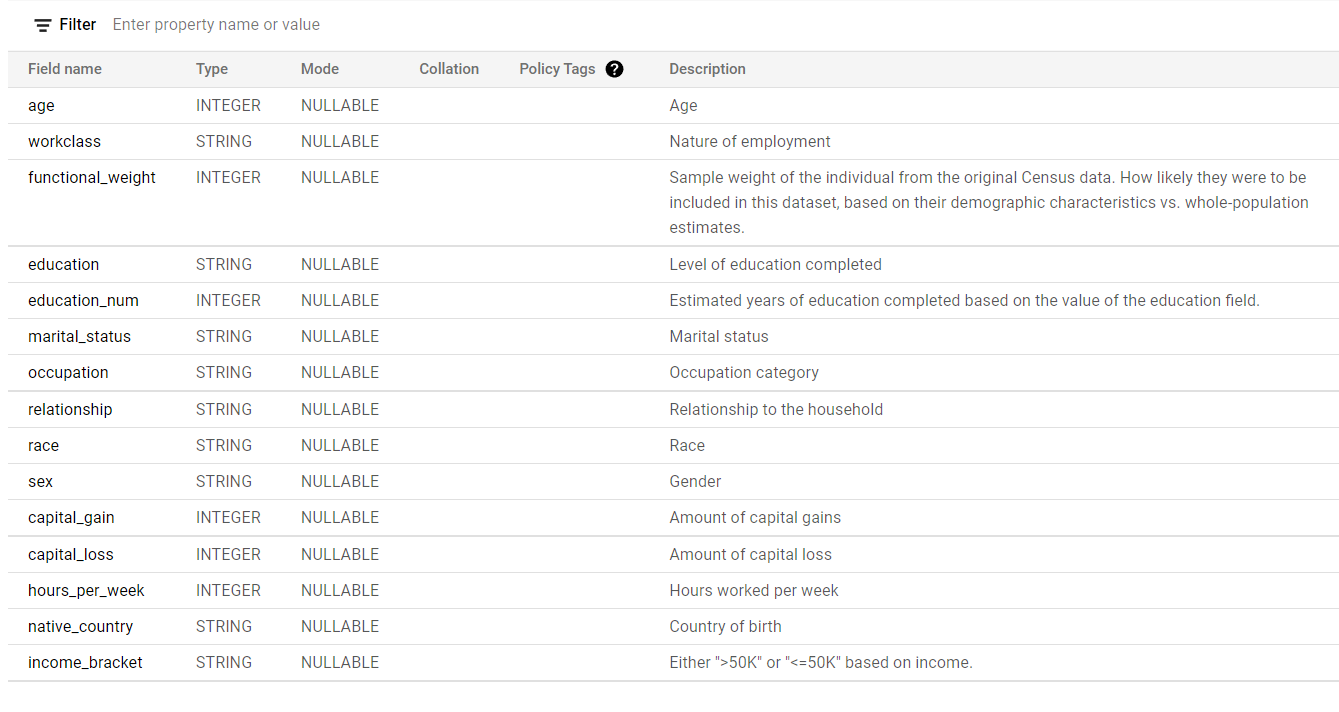

From the desciption we can see that all the data except age, capital_loss, hours_per_week, and capital_gain are categorical. in hindsight education_num seems to be numerical, but the data is infered from education column, both of them also have the same number of unique values. we can split the columns now for future analysis.

In [18]:
#Spliting numerical and categorical columns
col_num = ['age', 'capital_loss', 'hours_per_week', 'capital_gain']
col_cat = ['sex', 'income_bracket', 'race', 'relationship', 'marital_status', 
           'workclass', 'occupation', 'education', 'education_num', 'native_country']

Now I want to see the values of columns that have unique values less than 50

In [19]:
#Identifying unique values
unique_val = {}
unique_val_list =[]

for i in df.columns:
    if len(df[i].unique()) < 50:
        unique_val[i] = df[i].unique()
        unique_val_list.append(i)
        
for key in unique_val:
    print(key, ' : ', unique_val[key])

workclass  :  ['Private' 'Self-emp-not-inc' 'State-gov' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Never-worked' 'Without-pay']
education  :  ['HS-grad' 'Some-college' 'Assoc-voc' 'Assoc-acdm' 'Masters' '10th'
 'Bachelors' 'Prof-school' '5th-6th' '9th' 'Doctorate' '11th' '7th-8th'
 '12th' '1st-4th' 'Preschool']
education_num  :  [ 9 10 11 12 14  6 13 15  3  5 16  7  4  8  2  1]
marital_status  :  ['Never-married' 'Married-civ-spouse' 'Divorced' 'Widowed' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation  :  ['Adm-clerical' 'Farming-fishing' 'Protective-serv' 'Machine-op-inspct'
 'Other-service' 'Prof-specialty' 'Transport-moving' 'Exec-managerial'
 'Sales' 'Handlers-cleaners' 'Tech-support' 'Priv-house-serv'
 'Craft-repair' 'Armed-Forces' nan]
relationship  :  ['Not-in-family' 'Husband' 'Wife' 'Other-relative' 'Unmarried' 'Own-child']
race  :  ['White' 'Black' 'Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Other']
sex  :  ['Female' 'Male']
native_country  :  ['United-Sta

I think almost all data content are written quite clearly. some that need explanations are: for workclass incorporated (Self-emp-inc) and not incorporated (Self-emp-not-inc) is a description for self employed people. for marital status married_af_spouse means married to US armed forces.

One last interesting note is the income bracket are only split into two categories <=50K and >50K. 

Next we can divide the categorical columns into ordinal and nominal columns lists

In [20]:
#setting numerical, categorical ordinal and categorical nominal columns list
col_cat_ordinal = ['education','education_num','income_bracket']
col_cat_nominal = ['workclass', 'marital_status','occupation','relationship','race','sex','native_country']

## Income Bracket Analysis

income_bracket
<=50K    14939
>50K      5001
Name: age, dtype: int64

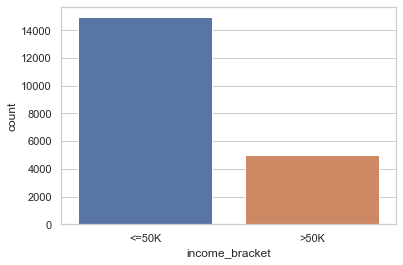

In [21]:
# Income bracket count plot
sns.countplot(data=df,x='income_bracket')
income_bracket_count = df.groupby(['income_bracket'])['age'].count()
income_bracket_count

As we can see here the <=50K income braket (which we will call as lower income bracket from now on) have almost three times frequency at almost 15,000 data points compared to the higher (>50K) income bracket at 5,001 data points.

Next we will try to see any pattern in every features values by comparing the percentage of values in each income bracket.  

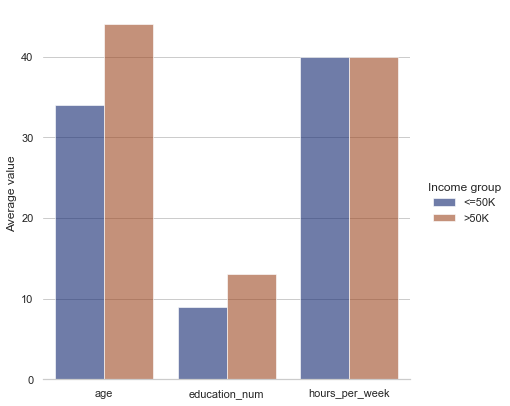

In [22]:
# Percentage dataframe
df_plot = df.groupby(['income_bracket']).median().reset_index()
df_plot = df_plot[['income_bracket', 'age','education_num','hours_per_week']]
df_plot = df_plot.melt(id_vars=['income_bracket'])

# Ploting grouped barchart
g = sns.catplot(
    data=df_plot, kind="bar",
    x="variable", y="value", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Average value")
g.legend.set_title("Income group")

We can see here that the wealthier group on average are older and more educated. interestingly, wealthier people seems spend the same amount of time working compared to their lower income counterpart.

Next we will try to dive deeper into each features.

In [23]:
# Income bracket mean for numerical columns
income_bracket_mean = df.groupby(['income_bracket']).mean()
income_bracket_mean

,age,education_num,capital_gain,capital_loss,hours_per_week
income_bracket,,,,,
<=50K,36.601178,9.628154,156.672334,53.655064,39.260861
>50K,44.088782,11.617477,4076.927215,198.546491,45.615477


here we can see the mean value of every numerical features, but how they compare? lets dive deeper.

<AxesSubplot:xlabel='income_bracket', ylabel='age'>

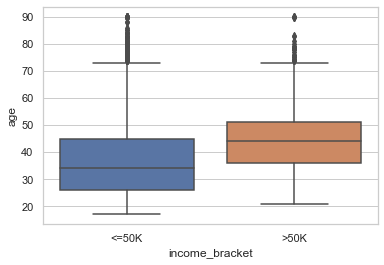

In [24]:
# age box plot divided by income groups
sns.boxplot(x='income_bracket',y='age',data=df)

As we can see before, the median value of wealthier group is higher than the lower income group. their minimum value is also higher but their q3 and max values are relatively similar than the lower income group.

<AxesSubplot:xlabel='income_bracket', ylabel='education_num'>

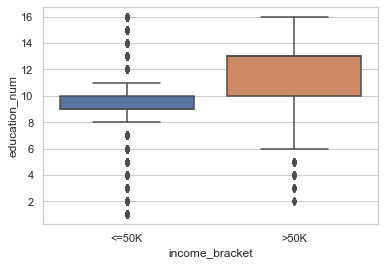

In [25]:
# education years box plot divided by income groups
sns.boxplot(x='income_bracket',y='education_num',data=df)

For education, we can see that the wealthier group have a higher median, but also higher variance compared to the lower income group. it means that wealthier people educational background are more diverse whilst on average they still spend more time for education.

<AxesSubplot:xlabel='income_bracket', ylabel='hours_per_week'>

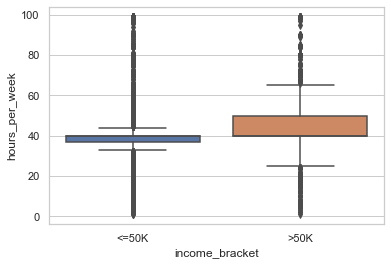

In [26]:
# hours of work per week box plot divided by income groups
sns.boxplot(x='income_bracket',y='hours_per_week',data=df)

Previously we saw that on average (median) lower and higher income groups spend the the same time working per week. interestingly, the higher income group is more spreadout in their working hour while majority of lower income people work around 40 hours per week.

Next we will analyze capital gain and capital lost.

<AxesSubplot:xlabel='income_bracket', ylabel='capital_loss'>

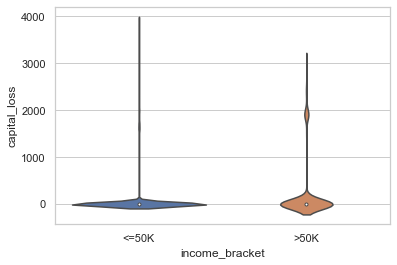

In [27]:
# capital loss violin plot divided by income groups
sns.violinplot(x='income_bracket',y='capital_loss',data=df)

We can see here that the average capital_loss is similar beteween the two income groups. A pattern that we saw repeating is how the variance of higher income group is higher. 

<AxesSubplot:xlabel='income_bracket', ylabel='capital_gain'>

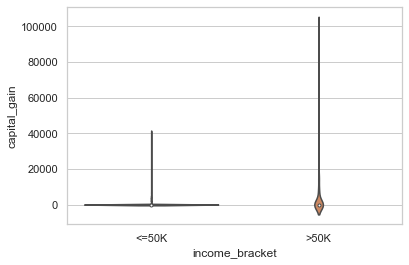

In [28]:
# capital gain violin plot divided by income groups
sns.violinplot(x='income_bracket',y='capital_gain',data=df)

<AxesSubplot:xlabel='income_bracket', ylabel='capital_gain'>

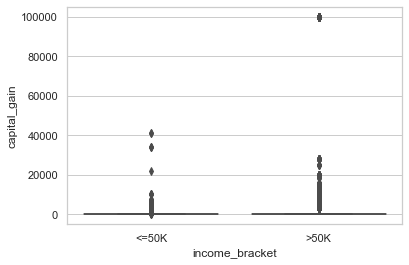

In [29]:
# capital loss box plot divided by income groups
sns.boxplot(x='income_bracket',y='capital_gain',data=df)

capital_gain distribution is similar to capital_loss with one exception. the higher income group capital gain reach into 100,000 USD maximum value. we can not gain many more insight from these graph other than that they have extreme ourliers. but how about its average, lets see in this table: 

In [30]:
# Income bracket mean for numerical columns
income_bracket_mean = df.groupby(['income_bracket'])[['capital_gain','capital_loss']].mean()
income_bracket_mean

,capital_gain,capital_loss
income_bracket,,
<=50K,156.672334,53.655064
>50K,4076.927215,198.546491


we can see that in average capital gain of higher income group is more than 20 times higher than the lower income group. on the other hand capital loss of the higher income group is only four times higher than the lower income group. It seems that while higher income people experince more loss than their lower income counterparts, they gain so much more in capital gain.

Next we would analyze the categorical columns.

In [31]:
# categorical columns list
col_cat

['sex',
 'income_bracket',
 'race',
 'relationship',
 'marital_status',
 'workclass',
 'occupation',
 'education',
 'education_num',
 'native_country']

We will try to analyze the colums one by one to see if there is any categorical pattern between lower and higher income groups.
We will try to plot the percentage of people who belong to one category compared to all people in their income group.

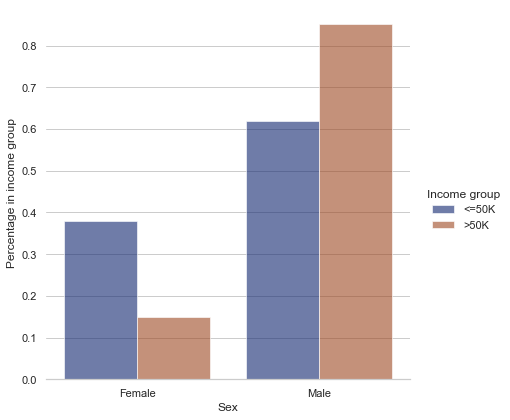

In [32]:
# Percentage dataframe
df_plot = df.groupby(['income_bracket', 'sex']).count().reset_index()


df_plot = df_plot[['income_bracket','sex', 'age']]

df_plot['percent'] = np.where(df_plot['income_bracket']=='<=50K', 
                              df_plot['age']/income_bracket_count[0], 
                              df_plot['age']/income_bracket_count[1])

# Ploting grouped barchart
g = sns.catplot(
    data=df_plot, kind="bar",
    x="sex", y="percent", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, height=6,

)
g.despine(left=True)
g.set_axis_labels("Sex", "Percentage in income group")
g.legend.set_title("Income group")

As we can see here, a higher income person is more likely to be male than female. more than 80% of higher income person is male and only about 60% of lower income people are male. It seems that income is more unequal on higher level.

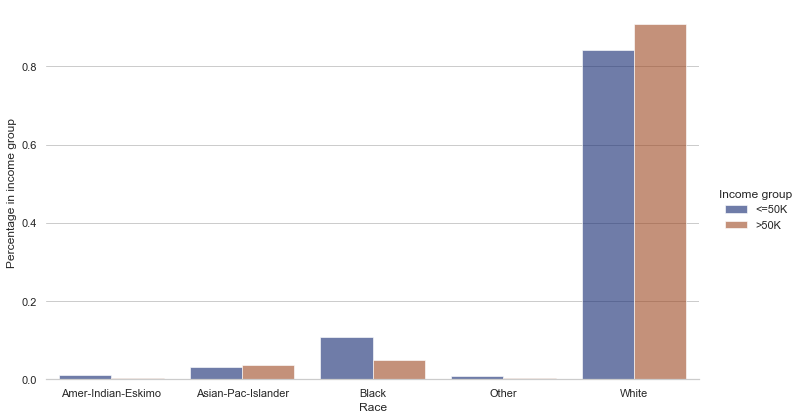

In [33]:
# Percentage dataframe
df_plot = df.groupby(['income_bracket', 'race']).count().reset_index()


df_plot = df_plot[['income_bracket','race', 'age']]

df_plot['percent'] = np.where(df_plot['income_bracket']=='<=50K', 
                              df_plot['age']/income_bracket_count[0], 
                              df_plot['age']/income_bracket_count[1])

# Ploting grouped barchart
g = sns.catplot(
    data=df_plot, kind="bar",
    x="race", y="percent", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, aspect=10/6, height=6,

)
g.despine(left=True)
g.set_axis_labels("Race", "Percentage in income group")
g.legend.set_title("Income group")

We can't see to clearly for the lower percentage races, we shoul pick the three bottom races to see them more clearly

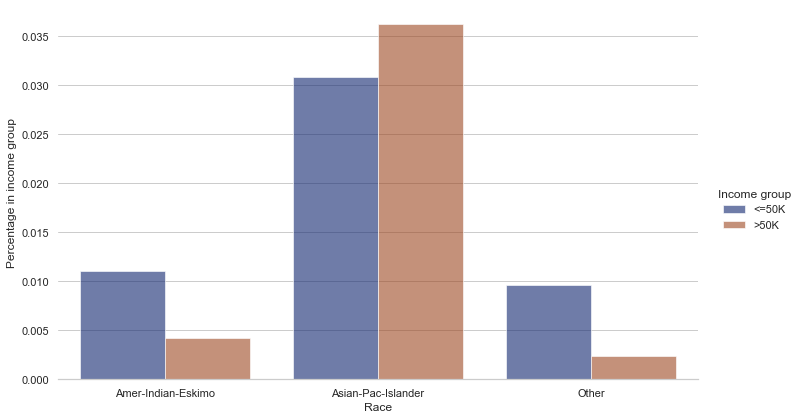

In [34]:
# Percentage dataframe
df_plot = df.groupby(['income_bracket', 'race']).count().reset_index()


df_plot = df_plot[['income_bracket','race', 'age']]

df_plot['percent'] = np.where(df_plot['income_bracket']=='<=50K', 
                              df_plot['age']/income_bracket_count[0], 
                              df_plot['age']/income_bracket_count[1])

df_plot = df_plot[df_plot['race'].isin(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Other'])]

# Ploting grouped barchart
g = sns.catplot(
    data=df_plot, kind="bar",
    x="race", y="percent", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, aspect=10/6, height=6,

)
g.despine(left=True)
g.set_axis_labels("Race", "Percentage in income group")
g.legend.set_title("Income group")

In terms of race, we can see that White and Asian-Pac-Islander, are slightly in higher proportion in the higher income group. On the other hand Black, Amer-Indian_Eskimo, and Other groups are disproportionaltely  higher on lower income group. In fact the proportion difference is 2-3 times higher.

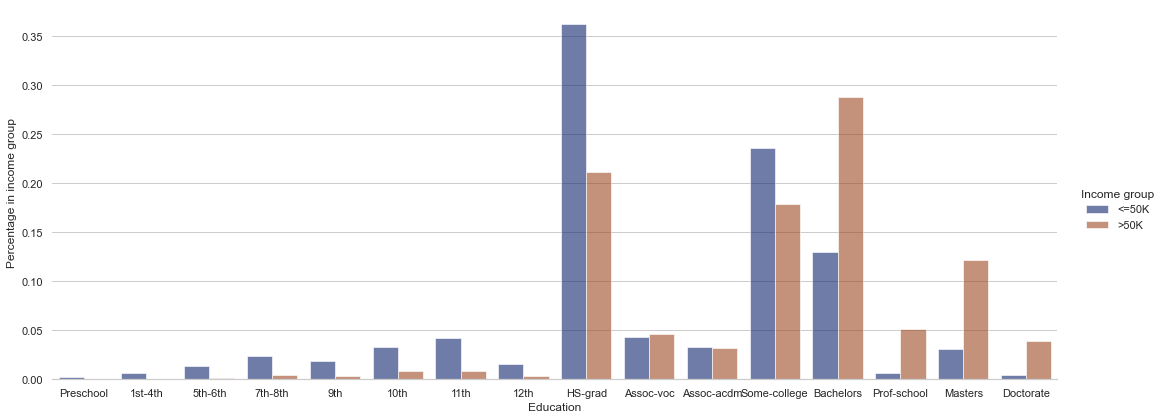

In [35]:
# Percentage dataframe
df_income_edu = df.groupby(['income_bracket', 'education']).count().reset_index()


df_income_edu = df_income_edu[['income_bracket','education', 'age']]

df_income_edu['percent'] = np.where(df_income_edu['income_bracket']=='<=50K', 
                                    df_income_edu['age']/income_bracket_count[0], 
                                    df_income_edu['age']/income_bracket_count[1])

# Ploting grouped barchart
g = sns.catplot(
    data=df_income_edu, kind="bar",
    x="education", y="percent", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, aspect=15/6, height=6,
    order=['Preschool', "1st-4th", "5th-6th", '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 
           'Assoc-voc', 'Assoc-acdm', 
           'Some-college', 'Bachelors', 'Prof-school', 'Masters', 'Doctorate']
)
g.despine(left=True)
g.set_axis_labels("Education", "Percentage in income group")
g.legend.set_title("Income group")

There is several outakes that we can make from this graph. First the lower income grup have a higher proportion lower education groups. It consistently higher from preschool to high school graduate which it is 1.75 times higher in proportion in lower income group. the frequency on associate vocational and associate academy school is relatively the same but we would see more difference in higher eduaction backgrounds.

for Bachelors degree it depends on either the person graduate or not. For lower income group, if the person was not graduated, the proprtion is higher. But for higher income group, the proportion of bachelor, professional school, Masters, and Doctorate are much higher compared to lower income group. this means you're likely to find more educated people in higher income group.

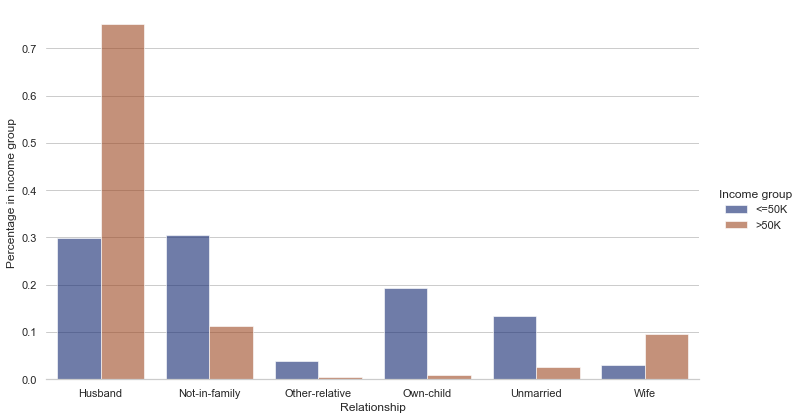

In [36]:
# Percentage dataframe
df_plot = df.groupby(['income_bracket', 'relationship']).count().reset_index()


df_plot = df_plot[['income_bracket','relationship', 'age']]

df_plot['percent'] = np.where(df_plot['income_bracket']=='<=50K', 
                              df_plot['age']/income_bracket_count[0], 
                              df_plot['age']/income_bracket_count[1])

# Ploting grouped barchart
g = sns.catplot(
    data=df_plot, kind="bar",
    x="relationship", y="percent", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, aspect=10/6, height=6,

)
g.despine(left=True)
g.set_axis_labels("Relationship", "Percentage in income group")
g.legend.set_title("Income group")

For relationship status, it seems that in higher income group the proportion of husband or wife are so much higher comapred to the lower income group., lets zoom into the these two group. 

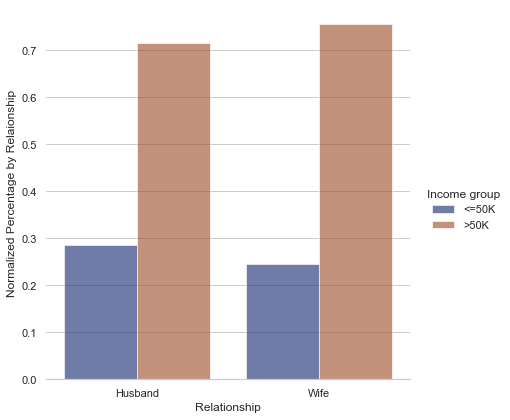

In [37]:
# Percentage dataframe
df_plot = df.groupby(['income_bracket', 'relationship']).count().reset_index()


df_plot = df_plot[['income_bracket','relationship', 'age']]

df_plot['percent'] = np.where(df_plot['income_bracket']=='<=50K', 
                              df_plot['age']/income_bracket_count[0], 
                              df_plot['age']/income_bracket_count[1])

df_plot = df_plot[df_plot['relationship'].isin(['Husband','Wife'])]

df_compare = df_plot.groupby(['relationship'])['percent'].sum()
df_compare = df_compare.loc[['Husband','Wife']]

df_plot['percent2'] = np.where(df_plot['relationship']=='Husband', 
                              df_plot['percent']/df_compare[0], 
                              df_plot['percent']/df_compare[1])

# Ploting grouped barchart
g = sns.catplot(
    data=df_plot, kind="bar",
    x="relationship", y="percent2", hue="income_bracket",
    ci="sd", palette="dark", alpha=.6, height=6,

)
g.despine(left=True)
g.set_axis_labels("Relationship", "Normalized Percentage by Relaionship")
g.legend.set_title("Income group")

As we can see here, there is not much diffrence in proportion of Husband and Wife  when we compare the two income group with the same amount of sample. 

## Corellation Analysis

Next we will be performing corellation analysis, this will be beneficial for feature selection later because we dont want to get columns that are highly corellated for regression models. Corellation analysis will also helps us gain insight into the data

In [38]:
# Preaparing Datafraeme
def cor_dataframe():
    df_corr = df.replace(["<=50K",'>50K'], [0, 1])
    df_corr = df_corr.replace(["Male",'Female'], [0, 1])
    return df_corr

df_corr = cor_dataframe()

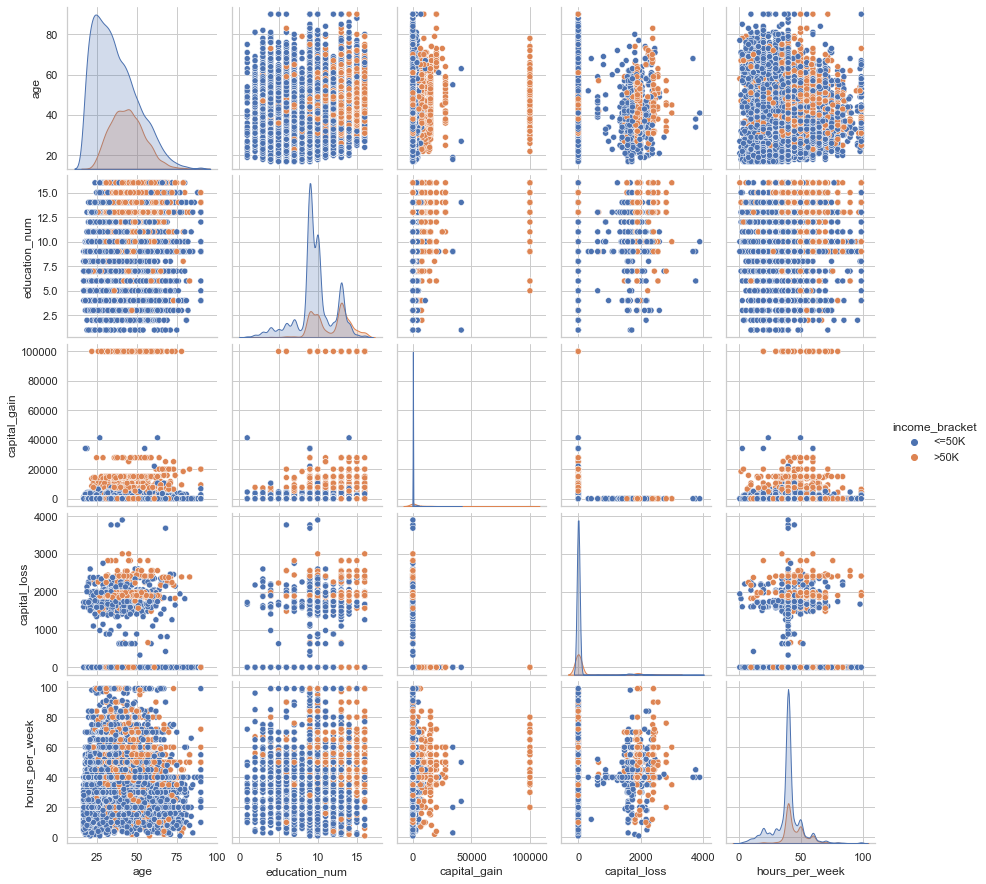

In [39]:
# Plotting Histogram and Scatter plots for every columnsb
sns.pairplot(df,diag_kind='kde', hue='income_bracket')

We can see here that from the scatter with income bracket hue, that there is some clustered pattern in most of the columns combnation. for example in age and capital gain combination, we can see that the higher income group seems be clustered at the top of the plot. anoher exapmple is in education_num with age, in this case the higher income bracket seems to clustered on the top right side for the plot. on the other hand, the overlap area between the scatter plots seems to be quite large, this can effect our svm/regression model accuracy later.

The histogram for for age, education and hours perweek also seems to confirm our earlier analysis. lower income group age and education is more skewed to the right compared to higher income group. hours per week distribution is similar but with steeper value around the center of 40 hours per week. 

<AxesSubplot:>

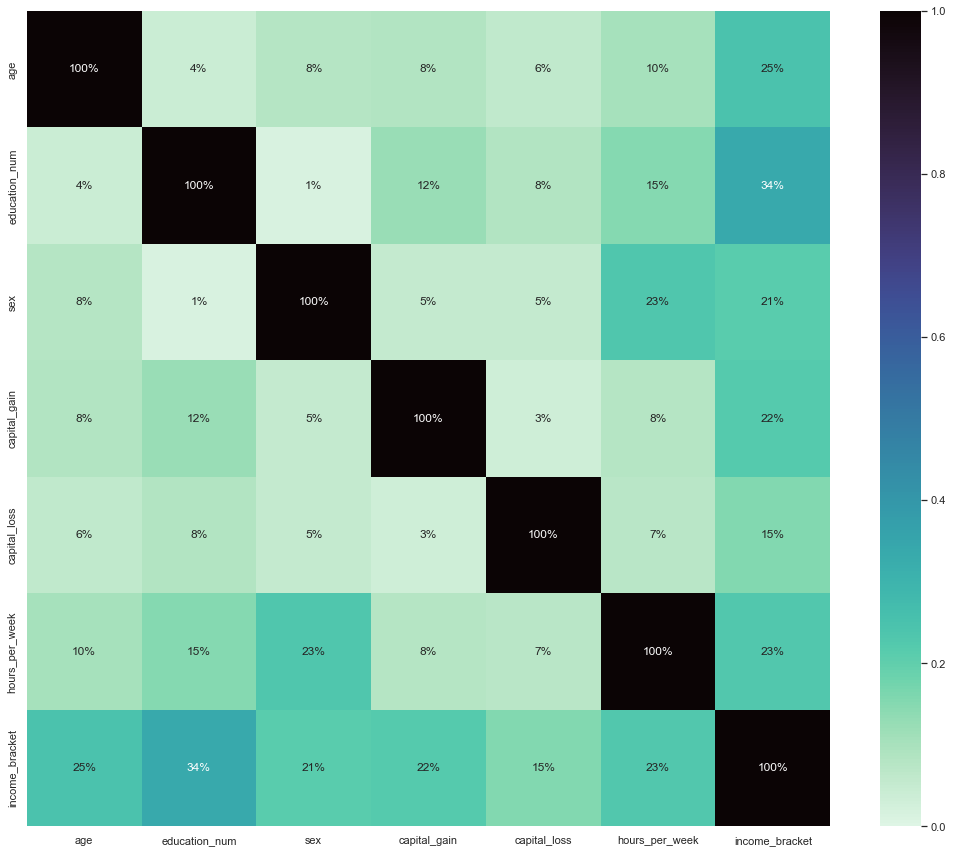

In [40]:
#Exploring corellation
cor_matrix = df_corr.corr().abs()

plt.figure(figsize = (18,15))
sns.heatmap(cor_matrix, annot=True, fmt=".0%", vmin=0, vmax=1, cmap="mako_r")

From the heatmap, we can see that the corelation between features (not income bracket) are lower than the income bracket.

on income bracket, the highest corelattion comes from education_num. capital gain, sex, and hours per week, are around 21-25% and capital loss have the lowest corelation with 15%

## Column Patterns

Now we want to detect the pattern of each columns and whether there are outliers and the types of outliers for each features. We also want to see if the features are normally distributed or not. this will be beneficial for outlier handling later and to gain insight into the data.

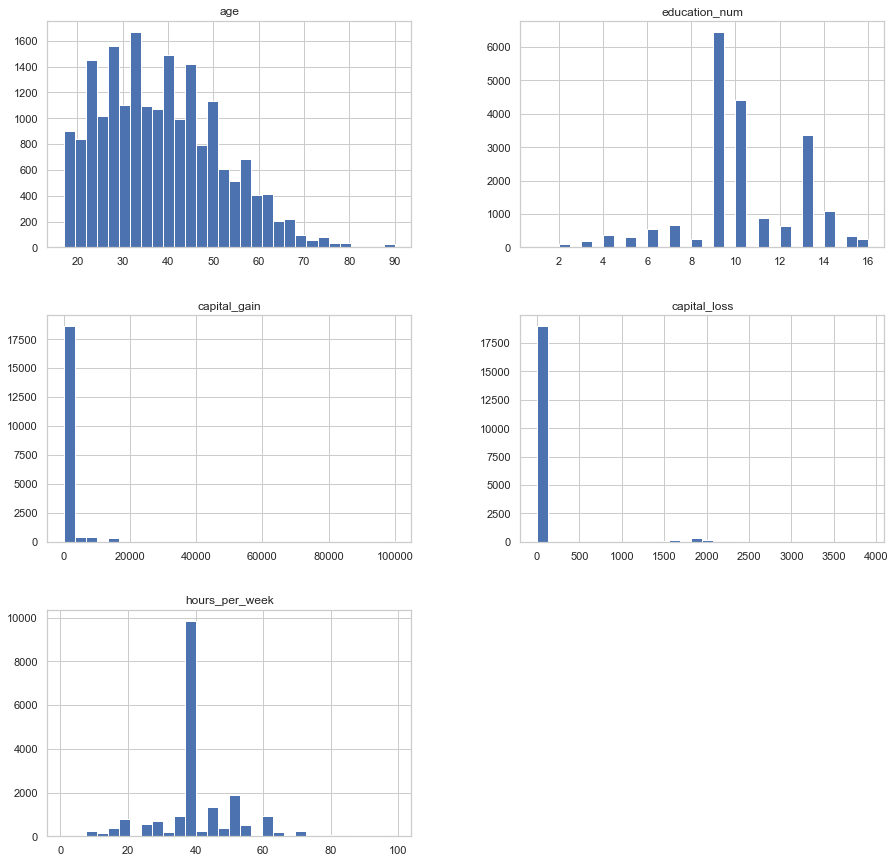

In [41]:
#plotting histogram for every numerical column
df.hist(bins=30, figsize=(15, 15));

In [42]:
#skew for each column
for column in df.select_dtypes(include=np.number).columns: 
    print(column, 'Skewness Value : ', df[column].skew())

age Skewness Value :  0.5307299635061905
education_num Skewness Value :  -0.32362979962057065
capital_gain Skewness Value :  11.561315899990174
capital_loss Skewness Value :  4.481198847362952
hours_per_week Skewness Value :  0.34184297535705394


In [43]:
#seperating by skewness
col_num_normal = [] 
col_num_skewed = []
col_num_skewed_extreme = []

for column in col_num:
    if abs(df[column].skew()) > 1:
        col_num_skewed_extreme.append(column)
    elif abs(df[column].skew()) > 0.5:
        col_num_skewed.append(column)
    else:
        col_num_normal.append(column)
        

print('extremely skewed: ', col_num_skewed_extreme) 
print('skewed:', col_num_skewed)
print('normal:', col_num_normal)

extremely skewed:  ['capital_loss', 'capital_gain']
skewed: ['age']
normal: ['hours_per_week']


As we can see from the histogram and the skewness calculation, age, capital_gain, and capital_loss are skewed to the right. moreover capital gain and capital loss are extremely skewed.

Education_num and hours per week is not skewed. for hours per week the frequency at 40 hours is the highest.

next we want to define function to plot histograms and boxplots for each feature to detect outliers

In [44]:
# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

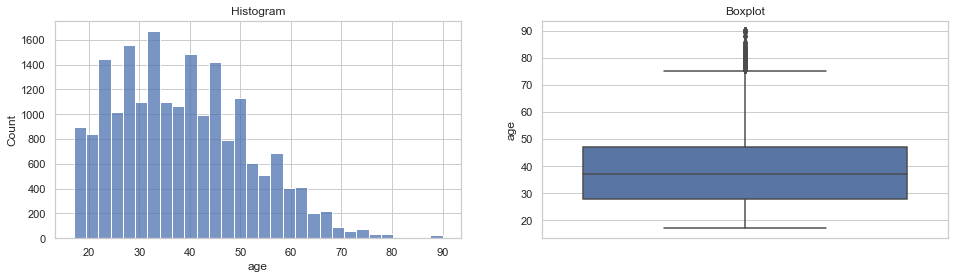


Skewness Value :  0.5307299635061905


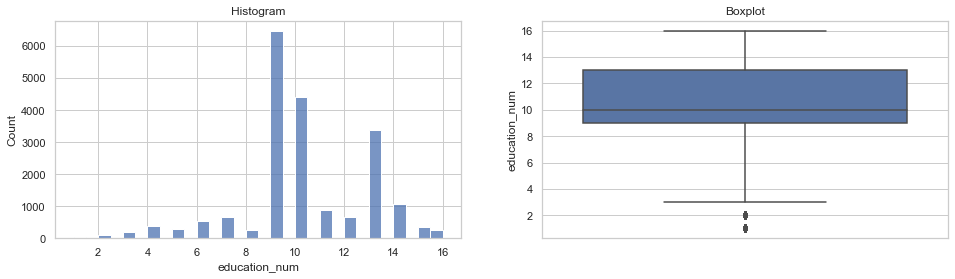


Skewness Value :  -0.32362979962057065


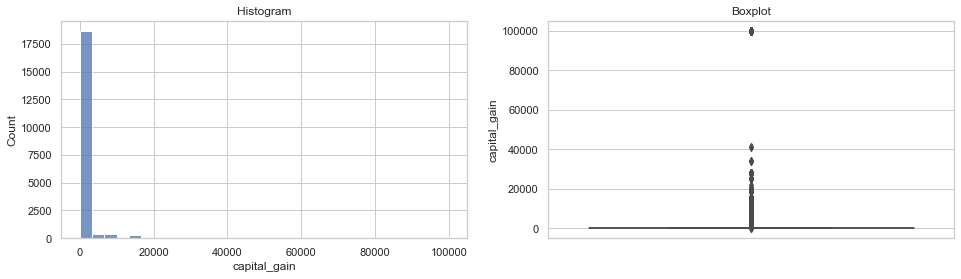


Skewness Value :  11.561315899990174


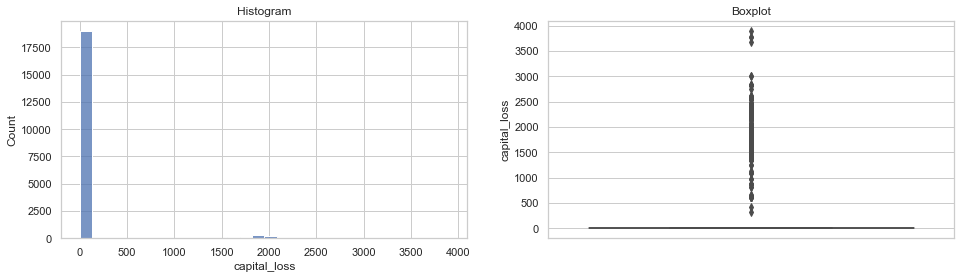


Skewness Value :  4.481198847362952


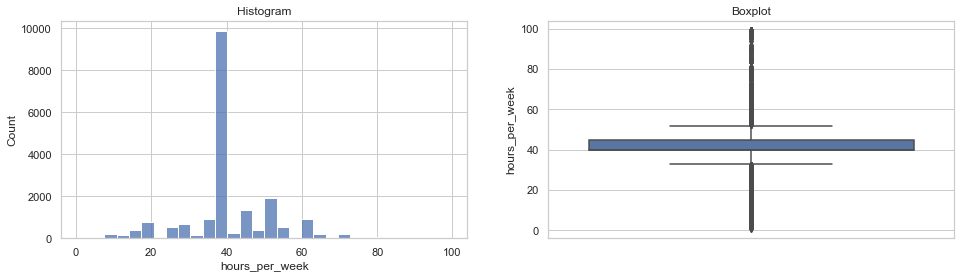


Skewness Value :  0.34184297535705394


In [45]:
for column in df.select_dtypes(include=np.number).columns: 
    diagnostic_plots(df, column)
    print('\nSkewness Value : ', df[column].skew())

In [46]:
#outlier lists
many_outlier = ['age', 'hours_per_week']
extreme_outlier = ['capital_loss', 'capital_gain']

We can see that all the data contains outliers, Age have lesser outliers than the others, and capital gain and loses data have an extreme ammount of outliers. based on this plot we can also choose to not handle capital gain and loss because the skew is result of natural occurance and the skew is also the charcter of the feature.

# Data Preprocessing

Now we can get into data pre-processing. in this part, we will split the data for train, test and Infernce, and then we will handle outlier, and if any we will also handle missing values.

## Get Data for Model Inference

In [47]:
# Get Data for Model Inference
data_inf = df.sample(100, random_state=21)

# Remove Inference-Set from Dataset
data_train_test = df.drop(data_inf.index)

print('Test Size  : ', data_inf.shape)

Test Size  :  (100, 14)


In [48]:
data_inf

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
15949,43,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,White,Female,0,0,24,United-States,<=50K
6468,19,Private,HS-grad,9,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
14270,52,Self-emp-inc,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
18876,35,State-gov,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1651,40,United-States,<=50K
14306,19,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,20,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18493,65,Self-emp-not-inc,11th,7,Married-civ-spouse,Exec-managerial,Husband,White,Male,9386,0,59,NaN,>50K
6830,58,Private,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
5264,27,State-gov,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,3411,0,40,United-States,<=50K
9076,39,Private,Some-college,10,Separated,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K


From the data, I'll split 100 rows as inference. This will helps us check the performance of our model.

## Splitting Dataset

In [49]:
#Setting price as target (y) and other data as features(X) 
X = data_train_test.drop('income_bracket', axis=1)
y = data_train_test['income_bracket']


#Splitting Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)
print('Inference Size  : ', data_inf.shape)

Train Size :  (15872, 13)
Test Size  :  (3968, 13)
Inference Size  :  (100, 14)


In [50]:
col_X = X.columns

After we split the inference, then we need to split train and test datasets. I choose to take 20% data as test and 80% as train. 

## Handling Outlier

As I stated above, I choose to handle outlier only only age and hours_per_week feature. The capital gain and capital loss data will be kept as is because it's the character of the data and outlier handling would eliminate most of the meaningful data.

In [51]:
#Outliers column
many_outlier

['age', 'hours_per_week']

In [52]:
#All numerical columns
col_num

['age', 'capital_loss', 'hours_per_week', 'capital_gain']

In [53]:
#Censoring with IQR
windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables= many_outlier)

windsoriser.fit(X_train)

X_train_censored = windsoriser.transform(X_train)
X_test_censored = windsoriser.transform(X_test)

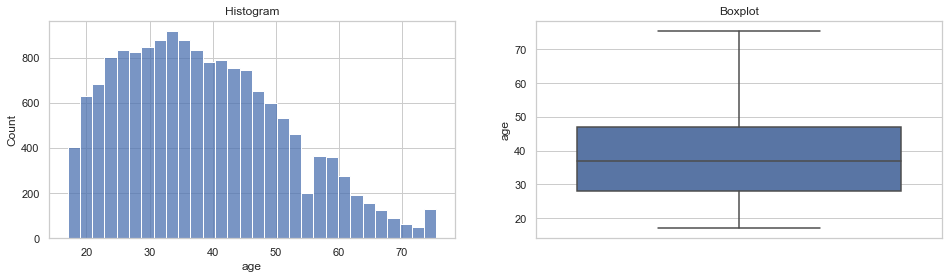


Skewness Value :  0.5332209528184777


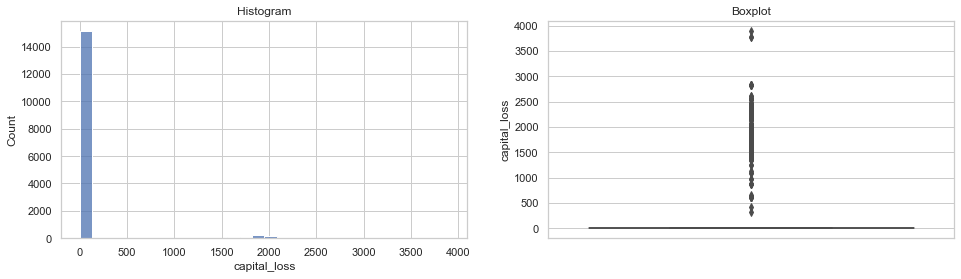


Skewness Value :  4.516088146293636


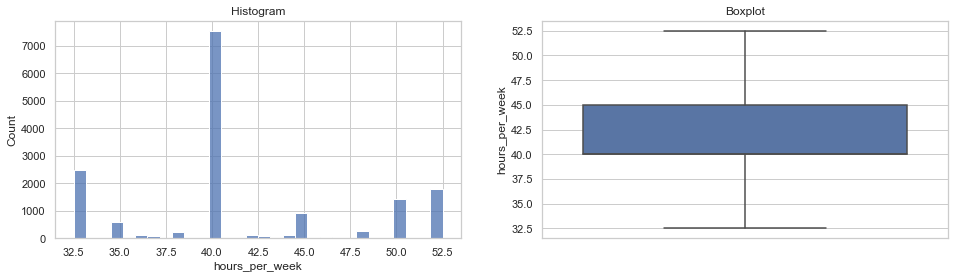


Skewness Value :  0.3655556403612474


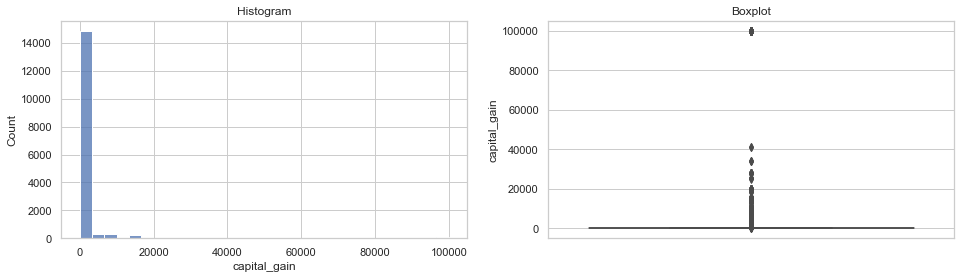


Skewness Value :  11.639095808099379


In [54]:
for column in col_num: 
    diagnostic_plots(X_train_censored, column)
    print('\nSkewness Value : ', X_train[column].skew())

After handling, we can see that our outliers are removed from age and hours per week data. The capital loss and capital gain stay as is because handling these features would remove meaningful data from the features

## Handling Missing Values

In [55]:
#Confirming missing values
X_train_censored.isnull().sum()

age                 0
workclass           0
education           0
education_num       0
marital_status      0
occupation          4
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    292
dtype: int64

As we can see, there are a few missing values in the data. It is not that significant but because it is categorical, we can fill the missing values with its features mode.

In [56]:
imp_constant = SimpleImputer(strategy='most_frequent')

imp_constant.fit(X_train_censored)

X_train_censored_nonan = imp_constant.transform(X_train_censored)
X_test_censored_nonan = imp_constant.transform(X_test_censored)

X_train_censored_nonan = pd.DataFrame(X_train_censored_nonan, columns=X.columns)
X_test_censored_nonan = pd.DataFrame(X_test_censored_nonan, columns=X.columns)

After handling the categorical missing values with most frequent value in the feature, we can continue to feature selection and filtering

## Feature Selection

### 1. Reasoning

As our analysis before, we can list our feature as:

In [57]:
#Printing features as previosly filtered
print('All Col :',df.columns.tolist())

print('')

print('Categorical features :')
print('Ordinal :', col_cat_ordinal)
print('Nominal :', col_cat_nominal)

print('')

print('Numerical features :')
print('Normal :', col_num_normal)
print('Skewed :', col_num_skewed)
print('Exremely Skewed :', col_num_skewed_extreme)



All Col : ['age', 'workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income_bracket']

Categorical features :
Ordinal : ['education', 'education_num', 'income_bracket']
Nominal : ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

Numerical features :
Normal : ['hours_per_week']
Skewed : ['age']
Exremely Skewed : ['capital_loss', 'capital_gain']


In general every feature class is self explanatory. Some notes on choices that needs more explaination:

In hindsight education_num seems to be numerical, but the data is infered from education column, both of them also have the same number of unique values. so both are assigned to ordinal feature

As we can see before from the histogram and the skewness calculation, age, capital_gain, and capital_loss are skewed to the right. Other than that capital gain and capital loss are extremely skewed with very high skew value of four and eleven.

hours per week is the only feature that is not skewed.

Because education and education num is redundant, we can drop one of them. I choose to drop education because for machine education num contains more information than education.

In [58]:
#Dropping redundant column and target(income bracket)
col_cat_ordinal = ['education_num']

In [59]:
#Listing dropped features
[col for col in df.columns.tolist() if col not in (col_cat_ordinal+col_cat_nominal+col_num_normal+col_num_skewed+col_num_skewed_extreme)]

['education', 'income_bracket']

### 2. Split between Numerical Columns and Categorical Columns

In code below we split the columns by our choosen class like we described above

In [60]:
#Spliting numerical columns into normal, skewed and extremely skewed
X_train_normal = X_train_censored_nonan[col_num_normal]
X_test_normal = X_test_censored_nonan[col_num_normal]

X_train_skewed = X_train_censored_nonan[col_num_skewed]
X_test_skewed = X_test_censored_nonan[col_num_skewed]

X_train_skewed_extreme = X_train_censored_nonan[col_num_skewed_extreme]
X_test_skewed_extreme = X_test_censored_nonan[col_num_skewed_extreme]

#Splitting categorical columns into ordinal and nominal
X_train_ordinal = X_train_censored_nonan[col_cat_ordinal]
X_test_ordinal = X_test_censored_nonan[col_cat_ordinal]

X_train_nominal = X_train_censored_nonan[col_cat_nominal]
X_test_nominal = X_test_censored_nonan[col_cat_nominal]

## Scaling and Encoding

### Numerical Data

In [61]:
#Scaling Algorithms
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

standard_scaler.fit(X_train_normal)
minmax_scaler.fit(X_train_skewed)
robust_scaler.fit(X_train_skewed_extreme)

X_train_normal_scaled = standard_scaler.transform(X_train_normal)
X_test_normal_scaled = standard_scaler.transform(X_test_normal)

X_train_skewed_scaled = minmax_scaler.transform(X_train_skewed)
X_test_skewed_scaled = minmax_scaler.transform(X_test_skewed)

X_train_skewed_extreme_scaled = robust_scaler.transform(X_train_skewed_extreme)
X_test_skewed_extreme_scaled = robust_scaler.transform(X_test_skewed_extreme)


We are using Standard Scaler for normally distributed data, MinMax scaler for skewed data and robust scaler for extremely skewed data. Each scaler are designed for specific function and we are splitting our data accordingly to achieve optimal value for our model.

### Categorical Data

In [62]:
# Feature Encoding using OrdinalEcoder
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder()

ordinal_encoder.fit(X_train_ordinal.astype(int))
onehot_encoder.fit(X_train_nominal)

X_train_ordinal_encoded = ordinal_encoder.transform(X_train_ordinal.astype(int))
X_test_ordinal_encoded = ordinal_encoder.transform(X_test_ordinal.astype(int))

X_train_nominal_encoded = onehot_encoder.transform(X_train_nominal).toarray()
X_test_nominal_encoded = onehot_encoder.transform(X_test_nominal).toarray()

# Target Encoding using OrdinalEcoder
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

For categorical data, we are using ordinal encoder for ordinal data and OneHot encoder for nominal data. as the scaler, these encoder are design for are designed for specific function and we are splitting our data accordingly to achieve optimal value for our model.

## Concating Data for Modeling

In [63]:
#Concating data as array
X_train_final = np.concatenate([X_train_normal_scaled, X_train_skewed_scaled, X_train_ordinal_encoded, X_train_nominal_encoded], axis=1)
X_test_final = np.concatenate([X_test_normal_scaled, X_test_skewed_scaled, X_test_ordinal_encoded, X_test_nominal_encoded], axis=1)

In [64]:
#Defining column names
column_names = [col_num_normal+col_num_skewed+col_cat_ordinal+col_cat_nominal+['onehot']*76]

In [65]:
#Model to dataframe
X_train_final_df = pd.DataFrame(X_train_final, columns=column_names)
X_test_final_df = pd.DataFrame(X_test_final, columns=column_names)

# Model Definition, Training, and Prediction

## SVM (SVC)

SVM or Support Vector Machine is machine learning algorthim that would classify data categories by splitting the data with dimensional hyperplane. SVM is one of the most robust prediction method. SVM is very versetile because we can apply kernel tricks to handle non linear boundaries.

In this project we will apply SVC or Support Vector Classification, a variant of SVM which focused on classification

In [66]:
# Train the Model
svm_model = SVC(kernel = 'linear', C = 100, gamma = 100)
svm_model.fit(X_train_final, y_train)

y_pred_train_svm = svm_model.predict(X_train_final)
y_pred_test_svm = svm_model.predict(X_test_final)

In this model i choose to use linear as general kernel because it looks like that our data have a linear separation pattern. I also choose higher C = 100 and gamma = 100 to handle more intricacies in the data. I choose to do this because our data is overlapping thus needs more fine seperation boundaries.

## Logistic Regression

Logisitic Regression is a model which use regression method to predict discreet values.

In [67]:
# Train the Model
log_model = LogisticRegression(max_iter = 1000, C = 1000)
log_model.fit(X_train_final, y_train)

y_pred_train_log = log_model.predict(X_train_final)
y_pred_test_log = log_model.predict(X_test_final)

In this model I choose even higher C than in SVC to see the impact of higher C in the model. I already tried C = 100 in logistic regression and interestingly the result is very similar to SVC. max_iter is set because the model need more than the deafult 100 to complete calculation

# Model Evaluation

## SVM (SVC)

In [68]:
#Train Classification Report
print(classification_report(y_train,y_pred_train_svm))

              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89     11896
        >50K       0.69      0.58      0.63      3976

    accuracy                           0.83     15872
   macro avg       0.78      0.75      0.76     15872
weighted avg       0.82      0.83      0.83     15872



In [69]:
#Test Classification Report
print(classification_report(y_test,y_pred_test_svm))

              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      2971
        >50K       0.72      0.56      0.63       997

    accuracy                           0.83      3968
   macro avg       0.79      0.74      0.76      3968
weighted avg       0.83      0.83      0.83      3968



1. From our report the first thing that I notice is how similar the train and test scores are. This shows that our model is not experiencing overfit. 
2. The precision (0,86), recall(0.93) and f1-score(0.89) for lower income braket is relatively higher compared to higher income bracket (0.72, 0.56, 0.63 respectively). This might be caused by data imbalance in our model. 

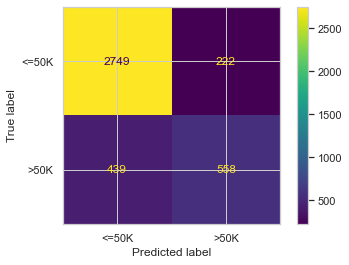

In [70]:
cm = confusion_matrix(y_test, y_pred_test_svm, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

From the confusion matrix we can confirm our test result. the frequency of True postive is very high, but the number of false negative and false postive are quite high. Our model can relatively accurately predict lower income data but fail to perform preidcition on higher income people.

In [71]:
def y_to_number(y):
    y = pd.Series(y)
    y_transformed = y.replace(["<=50K",'>50K'], [0, 1])
    return y_transformed

In [72]:
roc_auc_score(y_to_number(y_test), y_to_number(y_pred_test_log))

0.7429866172060443

Our ROC-AUC score is 0.74, this shows overall accuracy of our model which is better than when the model is ran with no paramter (~0.68). 

## Logistic Regression

In [73]:
print(classification_report(y_train,y_pred_train_log))

              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89     11896
        >50K       0.70      0.58      0.63      3976

    accuracy                           0.83     15872
   macro avg       0.78      0.75      0.76     15872
weighted avg       0.82      0.83      0.83     15872



In [74]:
print(classification_report(y_test,y_pred_test_log))

              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      2971
        >50K       0.72      0.56      0.63       997

    accuracy                           0.83      3968
   macro avg       0.79      0.74      0.76      3968
weighted avg       0.83      0.83      0.83      3968



1. Once again I saw that the train and test scores are very similar. The good news is this shows that our model is not experiencing overfit. One more takeaway is how similar the result from logistic regression and SVC with linear kernel. it might be because linear kernel SVC result in similar boundaries to logistic regression in the model. 
2. The precision (0,86), recall(0.93) and f1-score(0.89) for lower income braket is relatively higher compared to higher income bracket (0.72, 0.56, 0.63 respectively). This might be caused by data imbalance in our model. 

Just for curiousity's sake I'll try to comapre the two model classification report, is it that similar?

In [75]:
print(classification_report(y_pred_test_svm,y_pred_test_log))

              precision    recall  f1-score   support

       <=50K       0.98      0.98      0.98      3188
        >50K       0.94      0.93      0.93       780

    accuracy                           0.97      3968
   macro avg       0.96      0.96      0.96      3968
weighted avg       0.97      0.97      0.97      3968



It is very similar with all metrics showing value higher than 0.93

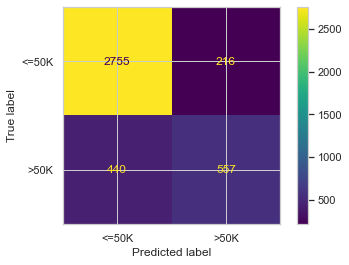

In [76]:
cm = confusion_matrix(y_test, y_pred_test_log, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

The conclusion from this graph is similar to the SVC one. We can confirm our test result. the frequency of True postive is very high, but the number of false negative and false postive are quite high. Our model can relatively accurately predict lower income data but fail to perform preidcition on higher income people.

In [77]:
def y_to_number(y):
    y = pd.Series(y)
    y_transformed = y.replace(["<=50K",'>50K'], [0, 1])
    return y_transformed

In [78]:
roc_auc_score(y_to_number(y_test), y_to_number(y_pred_test_log))

0.7429866172060443

Our ROC-AUC score is 0.74, this shows overall accuracy of our model which is better than when the model is ran with no paramter (~ sixty to seventy percent).

# Model Inference

## Inference Handling

In [79]:
data_inf = data_inf.reset_index(drop=True)

X_data_inf = data_inf.drop('income_bracket', axis=1)
y_data_inf = data_inf['income_bracket']

In [80]:
#Censoring outliers
data_inf_censored = windsoriser.transform(X_data_inf)

#Missing values handling
data_inf_censored_nonan = imp_constant.transform(data_inf_censored)
data_inf_censored_nonan = pd.DataFrame(data_inf_censored_nonan, columns=X.columns)

# Splitting between Numerical Columns and Categorical Columns
data_inf_normal = data_inf_censored_nonan[col_num_normal]
data_inf_skewed = data_inf_censored_nonan[col_num_skewed]
data_inf_skewed_extreme = data_inf_censored_nonan[col_num_skewed_extreme]

data_inf_ordinal = data_inf_censored_nonan[col_cat_ordinal]
data_inf_nominal = data_inf_censored_nonan[col_cat_nominal]

#Scaling and encdoing
data_inf_normal_scaled = standard_scaler.transform(data_inf_normal)
data_inf_skewed_scaled = minmax_scaler.transform(data_inf_skewed)
data_inf_skewed_extreme_scaled = robust_scaler.transform(data_inf_skewed_extreme)

data_inf_ordinal_encoded = ordinal_encoder.transform(data_inf_ordinal.astype(int))
data_inf_nominal_encoded = onehot_encoder.transform(data_inf_nominal).toarray()

data_inf_final = np.concatenate([data_inf_normal_scaled, data_inf_skewed_scaled, data_inf_ordinal_encoded, data_inf_nominal_encoded], axis=1)

#SVM prediction of data_inf
data_inf_pred_svm = svm_model.predict(data_inf_final)

#logistic regression prediction of data_inf
data_inf_pred_log = log_model.predict(data_inf_final)

## Inference Evaluation

## SVM (SVC)

In [81]:
#Train Classification Report
print(classification_report(y_data_inf,data_inf_pred_svm))

              precision    recall  f1-score   support

       <=50K       0.88      0.85      0.87        72
        >50K       0.65      0.71      0.68        28

    accuracy                           0.81       100
   macro avg       0.76      0.78      0.77       100
weighted avg       0.82      0.81      0.81       100



We can see here that our inference prediction shows similar result to train and test scores. this shows that our model is best fit even if not that accurate

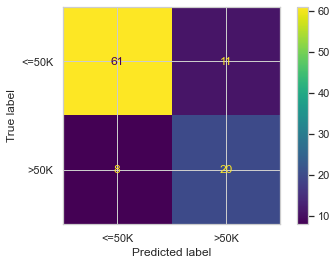

In [82]:
cm = confusion_matrix(y_data_inf, data_inf_pred_svm, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

From the confusion matrix we can confirm our test result. the frequency of True postive is very high, but the number of false negative and false postive are quite high. Our model can relatively accurately predict lower income data but fail to perform preidcition on higher income people.

In [83]:
def y_to_number(y):
    y = pd.Series(y)
    y_transformed = y.replace(["<=50K",'>50K'], [0, 1])
    return y_transformed

In [84]:
roc_auc_score(y_to_number(y_data_inf), y_to_number(data_inf_pred_svm))

0.7807539682539684

Our ROC-AUC score is 0.78 which is slightly higer than our train test model. this can be caused by limited number of sample (100)

## Logistic Regression

In [85]:
#Train Classification Report
print(classification_report(y_data_inf,data_inf_pred_log))

              precision    recall  f1-score   support

       <=50K       0.88      0.85      0.87        72
        >50K       0.65      0.71      0.68        28

    accuracy                           0.81       100
   macro avg       0.76      0.78      0.77       100
weighted avg       0.82      0.81      0.81       100



The score is exactly the same with svc-svm model we can also say that our inference prediction shows similar result to train and test scores. this shows that our model is best fit even if not that accurate

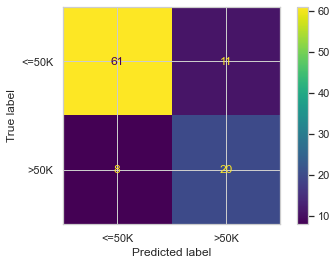

In [86]:
cm = confusion_matrix(y_data_inf, data_inf_pred_log, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

The confusion matrix is also the same so to repeat our last conclusion: We can confirm our test result. the frequency of True postive is very high, but the number of false negative and false postive are quite high. Our model can relatively accurately predict lower income data but fail to perform preidcition on higher income people.

In [87]:
def y_to_number(y):
    y = pd.Series(y)
    y_transformed = y.replace(["<=50K",'>50K'], [0, 1])
    return y_transformed

In [88]:
roc_auc_score(y_to_number(y_data_inf), y_to_number(data_inf_pred_log))

0.7807539682539684

Our ROC-AUC score is 0.78 exactly the same because both model produce exactly the same clasiffication result ([61,11],[8,29])

## Conclusion

In general our data shows many interesting corellation between the features, we built two models based on those features and we can say that our models can predict lower income data accurately but not higher income data. this can be caused by data imbalance so in the future we need to handle this.

### Questions & Answers

1. What is coeficient in logisitic regression?
    Coeficient in logistic regression is similar to the one in linear regression. it's value indicates the weight of each features. the diffrence to linear regression is the equation of logistic regression. instead of linear equation logistic regression use logarithm as y which can be written as 
    
    logit(p) = a+ bX₁ + cX₂ + ...
    
    
2. What is support vector in SVM
    Support vector in svm is points that are close to the margin on SVM. these points will help determine the maximum margin of svm.
    
3. What is the function of kernel in SVM, Explain one known kernel.
    kernel in svm helps us to transform data into linear model that can be seprated by hyperplane. for example if we have a circularly clustered data we can use something like 'z = x**2 + y**2' to transform the data so it can be separated into two groups by a line.
    
    One of the know kernel is polynomial kernel. this kernel can help us create hyperplane that is not linear (curvy) by using polynomial equaions.
    
Sources:

https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf

https://scikit-learn.org/stable/modules/svm.html

https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47#:~:text=Support%20vectors%20are%20data%20points,help%20us%20build%20our%20SVM.